# 1. Load dependencies

In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.base import clone 
from sklearn.model_selection import cross_val_score
from collections import Counter


# 2. Get Data

In [2]:
# Helper functions
def clean_cols(cols):
    cols_clean1 = cols.str.replace(' ', '_').str.replace('.', '')
    cols_clean2 = cols_clean1.str.replace('.', '') 
    cols_clean3 = [col.lower() for col in cols_clean2]
    return cols_clean3

In [3]:
# Get data from file path (downloaded from Kaggle)

file_path = "C:/Users/domen/github/pokemon_classification/datasets/Pokemon.csv"
df_raw = pd.read_csv(file_path)

# clean columns
df_raw.columns = clean_cols(df_raw.columns)

# convert columns with string values to lower
df_raw['type'] = df_raw.type.str.lower()
df_raw['other_type'] = df_raw.other_type.str.lower()
df_raw['name'] = df_raw.name.str.lower()


df_raw.head(3)

<ipython-input-2-b65e14a138b3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cols_clean1 = cols.str.replace(' ', '_').str.replace('.', '')
<ipython-input-2-b65e14a138b3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  cols_clean2 = cols_clean1.str.replace('.', '')


,pokedex_no,name,type,other_type,hp,attack,defense,special_attack,special_defense,speed,total,generation,legendary
0,1,bulbasaur,grass,poison,45,49,49,65,65,45,318,1,0
1,2,ivysaur,grass,poison,60,62,63,80,80,60,405,1,0
2,3,venusaur,grass,poison,80,82,83,100,100,80,525,1,0


In [4]:
# View a summary of counts for the target variable (legendary)
print("-- pct")
print(df_raw.legendary.value_counts(normalize=True))
print("-- counts")
print(df_raw.legendary.value_counts())

-- pct
0    0.878469
1    0.121531
Name: legendary, dtype: float64
-- counts
0    918
1    127
Name: legendary, dtype: int64


In [5]:
# Feature engineering

df_raw[df_raw.legendary==True].sort_values(by = 'total', ascending = False).head()
#df.sort_values(by = 'total', ascending = False).head(100)

# create a feature for all "variant form pokemon" (mega, ultra, primal, etc.)
df_raw['variant_ind'] = np.where(df_raw.name.str.startswith(("mega ", "ultra ", "primal ")), 1,
                             np.where(df_raw.name.str.endswith(("eternamax", "10% forme", "50% forme")), 1, 0))

# create a feature for all "forme" pokemon
df_raw['forme_ind'] = np.where(df_raw.name.str.endswith(("forme")), 1, 0)

# create a string version with a prefix for generation num
df_raw[['generation_nm']] = 'gen_' + df_raw['generation'].astype(str)

# see some of those
df_raw.sort_values(by = 'total', ascending = False).head(3)
#df_raw[df_raw.name.str.contains('forme')].head(3)

,pokedex_no,name,type,other_type,hp,attack,defense,special_attack,special_defense,speed,total,generation,legendary,variant_ind,forme_ind,generation_nm
1033,890,eternatus eternamax,poison,dragon,255,115,250,125,250,130,1125,8,1,1,0,gen_8
464,384,mega rayquaza,dragon,flying,105,180,100,180,100,115,780,3,1,1,0,gen_3
195,150,mega mewtwo y,psychic,NaN,106,150,70,194,120,140,780,1,1,1,0,gen_1


# 3. Data Preparation
* One-hot-encoding
* Dropping ID vars
* Normalizing (scaling) numeric data
* Feature selection

In [6]:
# Create dataframe for analysis
df = df_raw.copy()

# Filtering out variant_ind
df = df[df["variant_ind"] != 1]

# Create dummy variables
dummy_type1 = pd.get_dummies(df['type'], prefix='type1', drop_first=True)
dummy_type2 = pd.get_dummies(df['other_type'], prefix='type2', drop_first=True)

# Variables to drop
to_drop = ['pokedex_no', 'forme_ind', 'name', 'type', 'other_type', 'generation', 'generation_nm', 'total', 'variant_ind']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single data frame
merged = pd.concat([df, dummy_type1, dummy_type2], axis=1)

In [7]:
# uncomment to run correlation headtmap
# sns.heatmap(merged.corr(),annot=True)

In [8]:
# Setup train/test datasets

# drop target from train, keep in test
X = merged.drop('legendary', axis=1)
y = merged['legendary']

# Setyo train/test split of 75/25
X_train, X_test, y_train, y_test = train_test_split(
                                        X, 
                                        y, 
                                        test_size = 0.25, 
                                        random_state = 42
                                    )

In [40]:
# Setup sampling on the train datasets

# 4.2: SMOTE 50/50
#---

# define oversampling strategy, fit dataset
sm = SMOTE(sampling_strategy = 0.5, random_state = 42)
X_train2, y_train2 = sm.fit_resample(X_train, y_train)

# 4.3: Oversample with SMOTE 20/80, Undersample 50/50
#---

# define oversampling strategy, fit dataset
over = SMOTE(sampling_strategy = 0.2, random_state = 42)
X_train3, y_train3 = over.fit_resample(X_train, y_train)

# define undersampling strategy, fit dataset
under = RandomUnderSampler(sampling_strategy = 0.40)
X_train3, y_train3 = under.fit_resample(X_train3, y_train3)

# print out the shape of the data with and without SMOTE, then show the number of observations
print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train2.shape}
Shape of X after Combo: {X_train3.shape}''')

print('\nNORMAL:Balance of positive and negative classes (%):')
print(Counter(y_train))
print(y_train.value_counts(normalize=True) * 100)
#print(y_train.value_counts())

print('\nSMOTE: Balance of positive and negative classes (%):')
print(Counter(y_train2))
print(y_train2.value_counts(normalize=True) * 100)
#print(y_train2.value_counts())

print('\nCOMBO: Balance of positive and negative classes (%):')
print(Counter(y_train3))
print(y_train3.value_counts(normalize=True) * 100)
#print(y_train3.value_counts())

Shape of X before SMOTE: (743, 40)
Shape of X after SMOTE: (985, 40)
Shape of X after Combo: (458, 40)

NORMAL:Balance of positive and negative classes (%):
Counter({0: 657, 1: 86})
0    88.425303
1    11.574697
Name: legendary, dtype: float64

SMOTE: Balance of positive and negative classes (%):
Counter({0: 657, 1: 328})
0    66.700508
1    33.299492
Name: legendary, dtype: float64

COMBO: Balance of positive and negative classes (%):
Counter({0: 327, 1: 131})
0    71.39738
1    28.60262
Name: legendary, dtype: float64


# 4. Model Fit & Evaluation

In [11]:
# Build regression & random forest model for unbalanced datasets
lr = LogisticRegression(class_weight = 'balanced')
rf = RandomForestClassifier(class_weight = 'balanced')

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc, roc_curve

# Build models functions
#--------------

# Function to fit a random forest model
def fit_rf_model(x_train, y_train): 
    model = RandomForestClassifier(class_weight = 'balanced') # for unbalanced datasets
    model = model.fit(x_train, y_train)

    return model

# Function to fit a logistic regression model
def fit_lr_model(x_train, y_train):
    model = LogisticRegression(class_weight = 'balanced') # for unbalanced datasets
    model = model.fit(x_train, y_train)

    return model

# Feature importance functions
#--------------

# Function to extract top 10 features from a logistic regression
def rf_top_features(rf_model, X):
    rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns, name = 'rf_features')
    
    return rf_importance

# Function to extract top 10 features from a logistic regression
def lr_top_features(lr_model, train_x):
    lr_importance = pd.Series(lr_model.coef_[0], index=X.columns, name = 'lr_features')

    return lr_importance

# Model evaluation functions
#--------------

# Function to evaluate model
def evaluation(model, x_test, y_test, model_name):
    y_predict = model.predict(x_test) # get predictions
    y_predict_proba = model.predict_proba(x_test)[:, 1] # get prediction probabilities
    
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_predict_proba) # get precision recall curve datapoints
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_predict_proba) # get roc curve datapoints
    
    return y_predict, precision, recall, pr_thresholds, fpr, tpr, roc_thresholds, {
        f'{model_name} ROC AUC': auc(fpr, tpr), # Alternatively: roc_auc_score(y, y_predict_proba)
        f'{model_name} PR AUC': auc(recall, precision), # Alternatively (with slight difference): average_precision_score(y, y_predict_proba)

        f'{model_name} Precision': precision_score(y_test, y_predict),
        f'{model_name} Recall': recall_score(y_test, y_predict) 

            }

## 4.1 Non-SMOTE version
* **Model 1**: RF model
* **Model 2**: Logistic Regression model
* **Feature importance**: a quick look
* **Evaluation**: ROC-AUC, Precision & Recall

C:\Users\domen\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


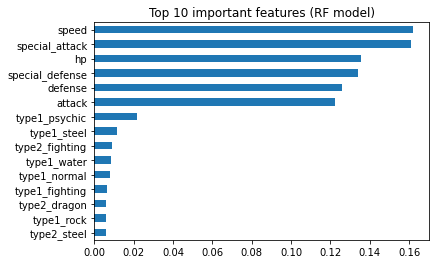

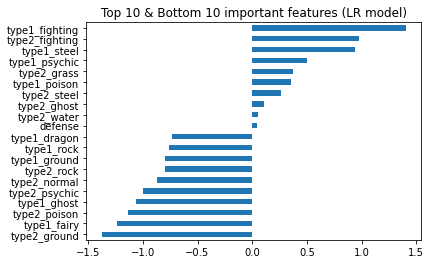

{'rf_model ROC AUC': 0.9790584159974807, 'rf_model PR AUC': 0.8890397950303752, 'rf_model Precision': 1.0, 'rf_model Recall': 0.5517241379310345}
{'lr_model ROC AUC': 0.949456778460085, 'lr_model PR AUC': 0.8593038783696122, 'lr_model Precision': 0.5094339622641509, 'lr_model Recall': 0.9310344827586207}


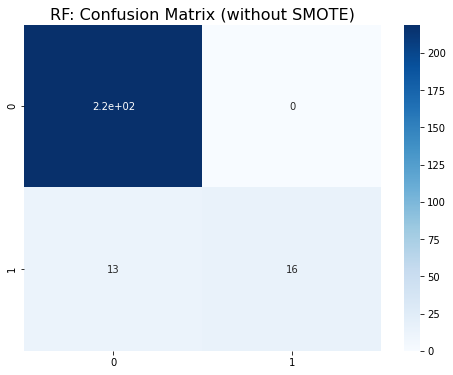

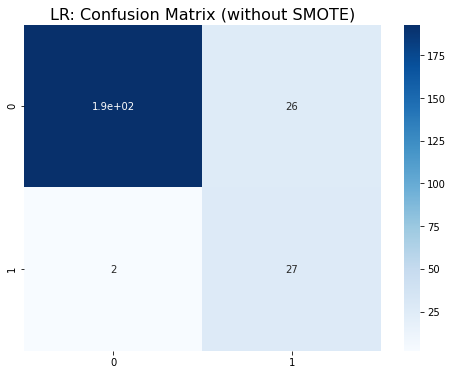

In [35]:
# Model fitting
#--------------

# fit a random forest (rf) & a logistic regression (lr) classifier
rf_model = fit_rf_model(X_train, y_train)
lr_model = fit_lr_model(X_train, y_train)

# Feature importance
#--------------

# top 10 feature importance for each model
rf_importance = rf_top_features(rf_model, X)
lr_importance = lr_top_features(lr_model, X)

# visualize top 10 in RF model
rf_importance.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features (RF model)")
plt.show()

# visualize top 10 positive, bottom 10 negative in LR model
lr_importance.nlargest(10).append(lr_importance.nsmallest(10)).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 & Bottom 10 important features (LR model)")
plt.show()

# Model evaluation
#--------------

# run the evaluation to get all desired metrics
rf_preds, rf_precision, rf_recall, rf_pr_thresholds, rf_fpr, rf_tpr, rf_roc_thresholds, rf_summary = evaluation(rf_model, X_test, y_test, "rf_model")
lr_preds, lr_precision, lr_recall, lr_pr_thresholds, lr_fpr, lr_tpr, lr_roc_thresholds, lr_summary = evaluation(lr_model, X_test, y_test, "lr_model")

# plot the RF confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
plt.title('RF: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(rf_cm, annot=True, cmap='Blues')

# plot the LF confusion matrix
lr_cm = confusion_matrix(y_test, lr_preds)
plt.figure(figsize=(8, 6))
plt.title('LR: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(lr_cm, annot=True, cmap='Blues')

# see the summary statistics
print(rf_summary)
print(lr_summary)

## 4.2 SMOTE version
* **Model 1**: RF model
* **Model 2**: Logistic Regression model
* **Feature importance**: a quick look
* **Evaluation**: ROC-AUC, Precision & Recall

C:\Users\domen\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


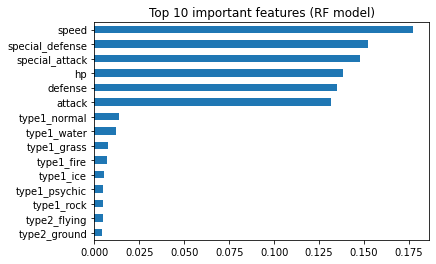

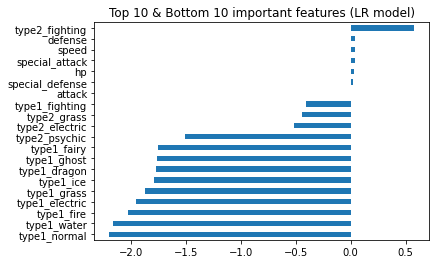

{'rf_model ROC AUC': 0.9659108801763502, 'rf_model PR AUC': 0.8777925510626619, 'rf_model Precision': 0.875, 'rf_model Recall': 0.7241379310344828}
{'lr_model ROC AUC': 0.952133522279956, 'lr_model PR AUC': 0.8663246781001308, 'lr_model Precision': 0.6578947368421053, 'lr_model Recall': 0.8620689655172413}


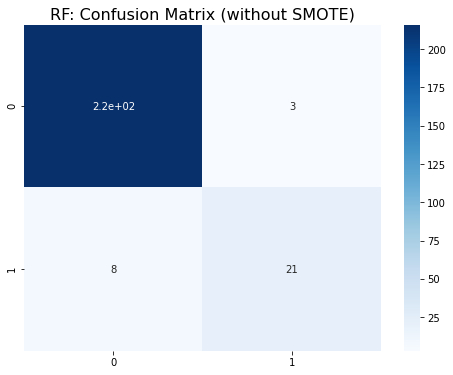

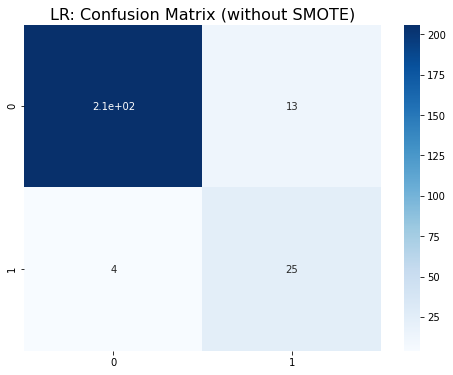

In [36]:
# Model fitting
#--------------

# fit a random forest (rf) & a logistic regression (lr) classifier
rf_model = fit_rf_model(X_train2, y_train2)
lr_model = fit_lr_model(X_train2, y_train2)

# Feature importance
#--------------

# top 10 feature importance for each model
rf_importance = rf_top_features(rf_model, X)
lr_importance = lr_top_features(lr_model, X)

# visualize top 10 in RF model
rf_importance.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features (RF model)")
plt.show()

# visualize top 10 positive, bottom 10 negative in LR model
lr_importance.nlargest(10).append(lr_importance.nsmallest(10)).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 & Bottom 10 important features (LR model)")
plt.show()

# Model evaluation
#--------------

# run the evaluation to get all desired metrics
rf_preds, rf_precision, rf_recall, rf_pr_thresholds, rf_fpr, rf_tpr, rf_roc_thresholds, rf_summary = evaluation(rf_model, X_test, y_test, "rf_model")
lr_preds, lr_precision, lr_recall, lr_pr_thresholds, lr_fpr, lr_tpr, lr_roc_thresholds, lr_summary = evaluation(lr_model, X_test, y_test, "lr_model")

# plot the RF confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
plt.title('RF: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(rf_cm, annot=True, cmap='Blues')

# plot the LF confusion matrix
lr_cm = confusion_matrix(y_test, lr_preds)
plt.figure(figsize=(8, 6))
plt.title('LR: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(lr_cm, annot=True, cmap='Blues')

# see the summary statistics
print(rf_summary)
print(lr_summary)

In [124]:
# TODO! This section needs work!

# Trying out cross-validation for model evaluation here (RF model only)

# get AUC, Recall & Accuracy
#rf_sm_cv_auc = cross_val_score(rf_sm_model, X_train2, y_train, cv=10, scoring='roc_auc')
#rf_sm_cv_precision = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='precision')
#rf_sm_cv_recall = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='recall')
#rf_sm_cv_accuracy = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='accuracy')
#rf_sm_cv_f1score = cross_val_score(rf_sm_model, X_sm, y_sm, cv=10, scoring='f1')

# print results
#print(f'RF: ROC AUC = {np.mean(rf_sm_cv_auc):.2f}')
#print(f'RF: Accuracy = {np.mean(rf_sm_cv_accuracy):.2f}')
#print(f'RF: Precision = {np.mean(rf_sm_cv_precision):.2f}')
#print(f'RF: Recall = {np.mean(rf_sm_cv_recall):.2f}')
#print(f'RF: F1 Score = {np.mean(rf_sm_cv_f1score):.2f}')

## 4.3 SMOTE Minority Class, Undersample Majority
* Smote = 10/90 split, Underample = 50/50 split
* **Model 1**: RF model
* **Model 2**: Logistic Regression model
* **Feature importance**: a quick look
* **Evaluation**: ROC-AUC, Precision & Recall

C:\Users\domen\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


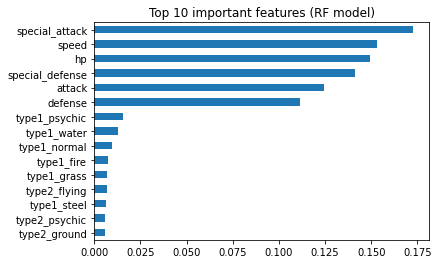

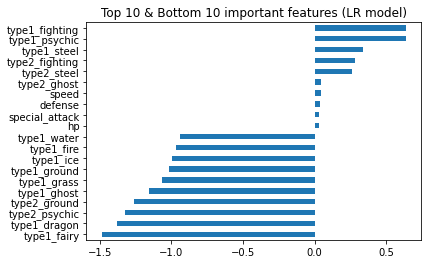

{'rf_model ROC AUC': 0.9583530152731853, 'rf_model PR AUC': 0.8611945050708166, 'rf_model Precision': 0.84, 'rf_model Recall': 0.7241379310344828}
{'lr_model ROC AUC': 0.9560699102503544, 'lr_model PR AUC': 0.8728553829820711, 'lr_model Precision': 0.6428571428571429, 'lr_model Recall': 0.9310344827586207}


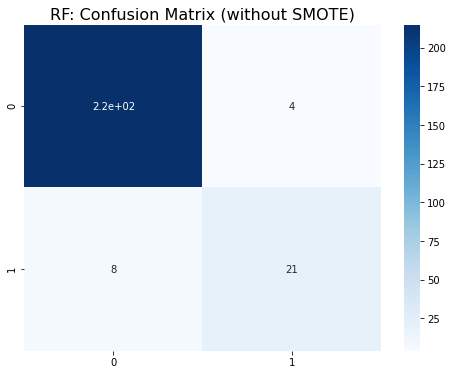

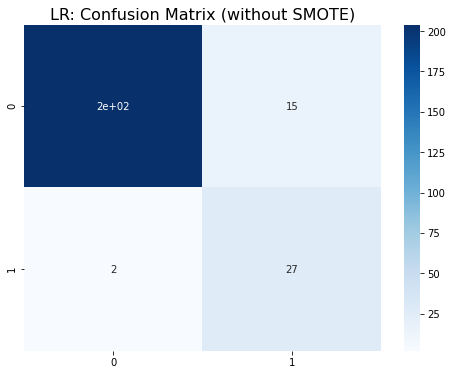

In [42]:
# Model fitting
#--------------

# fit a random forest (rf) & a logistic regression (lr) classifier
rf_model = fit_rf_model(X_train3, y_train3)
lr_model = fit_lr_model(X_train3, y_train3)

# Feature importance
#--------------

# top 10 feature importance for each model
rf_importance = rf_top_features(rf_model, X)
lr_importance = lr_top_features(lr_model, X)

# visualize top 10 in RF model
rf_importance.nlargest(15).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 important features (RF model)")
plt.show()

# visualize top 10 positive, bottom 10 negative in LR model
lr_importance.nlargest(10).append(lr_importance.nsmallest(10)).sort_values(ascending = True).plot(kind='barh')
plt.title("Top 10 & Bottom 10 important features (LR model)")
plt.show()

# Model evaluation
#--------------

# run the evaluation to get all desired metrics
rf_preds, rf_precision, rf_recall, rf_pr_thresholds, rf_fpr, rf_tpr, rf_roc_thresholds, rf_summary = evaluation(rf_model, X_test, y_test, "rf_model")
lr_preds, lr_precision, lr_recall, lr_pr_thresholds, lr_fpr, lr_tpr, lr_roc_thresholds, lr_summary = evaluation(lr_model, X_test, y_test, "lr_model")

# plot the RF confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
plt.title('RF: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(rf_cm, annot=True, cmap='Blues')

# plot the LF confusion matrix
lr_cm = confusion_matrix(y_test, lr_preds)
plt.figure(figsize=(8, 6))
plt.title('LR: Confusion Matrix (without SMOTE)', size=16)
sns.heatmap(lr_cm, annot=True, cmap='Blues')

# see the summary statistics
print(rf_summary)
print(lr_summary)